# Chapter 2 - Production

In [1]:
!pip install -Uqq fastbook
!pip install -Uqq jmd_imagescraper

     |████████████████████████████████| 727kB 11.9MB/s 
     |████████████████████████████████| 51kB 9.2MB/s 
     |████████████████████████████████| 1.2MB 56.6MB/s 
     |████████████████████████████████| 194kB 53.3MB/s 
     |████████████████████████████████| 61kB 10.5MB/s 


In [30]:
from pathlib import Path

import fastai.vision.all as vision
import fastai.vision.widgets as vision_widgets
import jmd_imagescraper.core as imagescraper
import requests

# Downloading Data

In [3]:
BEAR_PATH = Path('bears')

if not BEAR_PATH.exists():
  BEAR_PATH.mkdir()
  for bear in ['grizzly','black','teddy']:
      imagescraper.duckduckgo_search(
          BEAR_PATH, bear, f"{bear} bear", max_results=50, 
          img_layout=imagescraper.ImgLayout.All
      )

Duckduckgo search: grizzly bear


Duckduckgo search: black bear


Duckduckgo search: teddy bear


# From Data to DataLoaders

In [4]:
bears = vision.DataBlock(
    blocks=(vision.ImageBlock, vision.CategoryBlock), 
    get_items=vision.get_image_files, 
    splitter=vision.RandomSplitter(valid_pct=0.2, seed=42),
    get_y=vision.parent_label,
    item_tfms=vision.Resize(128)
)

In [5]:
dls = bears.dataloaders(BEAR_PATH)

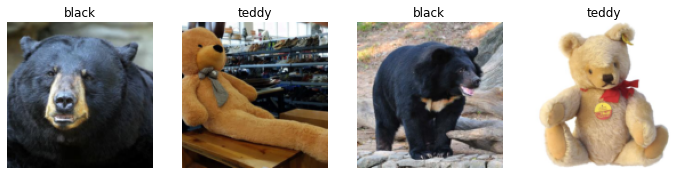

In [6]:
dls.valid.show_batch(max_n=4, nrows=1)

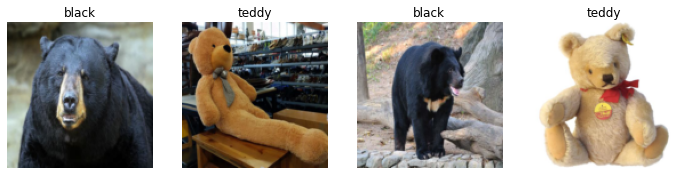

In [7]:
bears = bears.new(item_tfms=vision.Resize(128, vision.ResizeMethod.Squish))
dls = bears.dataloaders(BEAR_PATH)
dls.valid.show_batch(max_n=4, nrows=1)

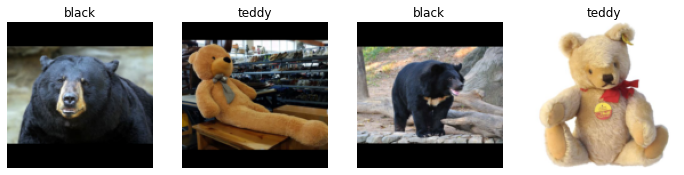

In [8]:
bears = bears.new(item_tfms=vision.Resize(128, vision.ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(BEAR_PATH)
dls.valid.show_batch(max_n=4, nrows=1)

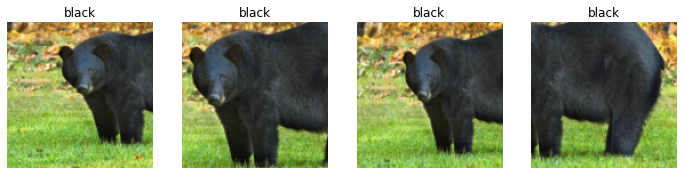

In [9]:
bears = bears.new(item_tfms=vision.RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(BEAR_PATH)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

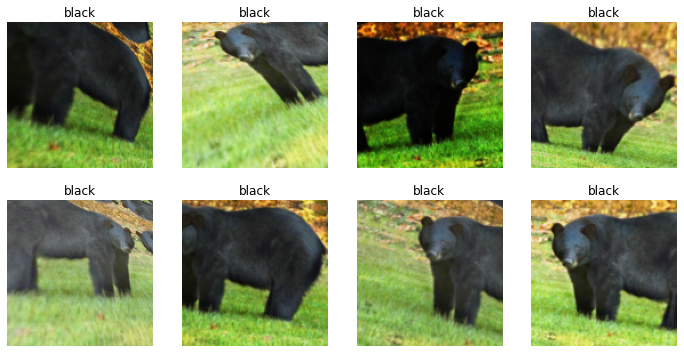

In [12]:
bears = bears.new(item_tfms=vision.Resize(128), batch_tfms=vision.aug_transforms(mult=2))
dls = bears.dataloaders(BEAR_PATH)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [13]:
bears = bears.new(
    item_tfms=vision.RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=vision.aug_transforms())
dls = bears.dataloaders(BEAR_PATH)

In [14]:
learn = vision.cnn_learner(dls, vision.resnet18, metrics=vision.error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,2.621150,2.413137,0.800000,00:01


epoch,train_loss,valid_loss,error_rate,time
0,2.551960,1.509626,0.666667,00:01
1,2.203501,0.312434,0.100000,00:01
2,1.689615,0.082407,0.000000,00:01
3,1.305494,0.049368,0.000000,00:01


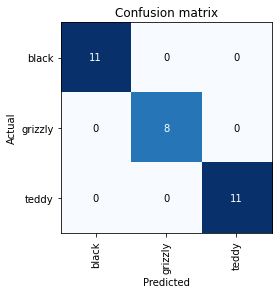

In [16]:
interp = vision.ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

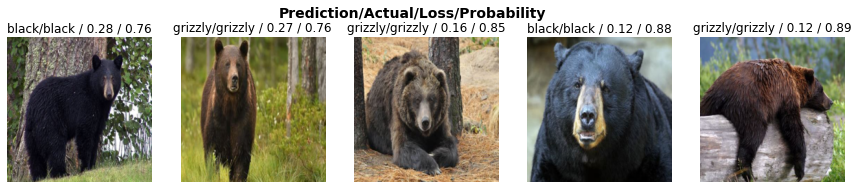

In [17]:
interp.plot_top_losses(5, nrows=1)

In [22]:
cleaner = vision_widgets.ImageClassifierCleaner(learn)
cleaner

In [23]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

### Using the Model for Inference

In [24]:
learn.export()

In [25]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [27]:
learn_inf = vision.load_learner(path/'export.pkl')

In [31]:
def which_bear(url):
  img = vision.PILImage.create(requests.get(url, stream=True).raw)
  bear, i ,probs = learn.predict(img)
  print(f"This is a {bear} bear")
  print(f"Probability: {probs[i].item():.6f}")
  return img.to_thumb(192)

This is a teddy bear
Probability: 0.999984


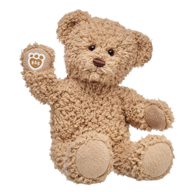

In [32]:
url = 'https://www.buildabear.co.uk/dw/image/v2/BBNG_PRD/on/demandware.static/-/Sites-buildabear-master/default/dwb8ba281b/26518x.jpg'
which_bear(url)

In [33]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']